In [1]:
import numpy as np
import math
%matplotlib inline

## get data
- random seed is convenient for comparison with the same shuffle effect
- there are two dataset,one is clean data , the other is noisy data

In [2]:
def getData(file):
    a = np.loadtxt(file)
    np.random.seed(36)
    np.random.shuffle(a)
    X = a[:,:-1]
    y = a[:,-1]
    return X,y

In [3]:
clean_file = "clean_dataset.txt"
noisy_file = "noisy_dataset.txt"
clean_X,clean_y = getData(clean_file)
noisy_X,noisy_y = getData(noisy_file)

## define entropy

In [4]:
#calculate information entropy
def calculate_entropy(y):
    """
    y : the sub-dataset
    """
    entropy = 0
    unique_y = np.unique(y)
    for label in unique_y:
        num = len(y[y == label])
        p = num / len(y)
        entropy += (-p)*math.log2(p)
    return entropy

## this is for visualizing decision tree(but you need to store the structure of tree in dictionary)
- install graphviz in advance

In [5]:
from graphviz import Digraph
import graphviz
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 

def plot_model(tree, name):
    g = Digraph("G", filename=name, format='png', strict=False)
    first_label = list(tree.keys())[0]
    g.node("0", first_label)
    _sub_plot(g, tree, "0")
    g.render(name, view=False)
    
    graph = mpimg.imread(name+'.png')
    plt.figure(figsize=(10, 10))
    plt.imshow(graph) 
    plt.axis('off')
    plt.show()
    
root = "0"
def _sub_plot(g, tree, inc):
    global root
    first_label = list(tree.keys())[0]
    ts = tree[first_label]
    if isinstance(ts, dict):
        for i in ts.keys():
            if isinstance(tree[first_label][i], dict):
                root = str(int(root) + 1)
                g.node(root, list(tree[first_label][i].keys())[0])
                g.edge(inc, root, str(i))
                _sub_plot(g, tree[first_label][i], root)
            else:
                root = str(int(root) + 1)
                g.node(root, tree[first_label][i])
                g.edge(inc, root, str(i))


## function to return all available splitting points
 
because there are all floating points,we have to sort the array first,then to choose the splitting positions.
the splitting rule is to choose the middle value between two consecutive floating values.
for example, if x = [1.2,3.4,5.6,7.8] , the possible splitting points should be [2.3,4.5,6.7]. 


In [6]:
#calculate the splitting point of continuous feature
def calculate_splitting_point(feature):
    """
    return a list with different splitting point
    """
    res = []
    sorted_fea = sorted(feature)
    for i in range(1,len(sorted_fea)):
        if sorted_fea[i] == sorted_fea[i-1]:
            continue
        else:
            middle = (sorted_fea[i] + sorted_fea[i-1]) / 2
            res.append(middle)
    return res

## function to return the best information gain for each feature

In [7]:
#calculate_information gain
def calculate_info_gain(dataset,y,feature):
    split_points = calculate_splitting_point(dataset[:,feature])
    #print(split_points)
    gain_list = [] # pairs [gain,splitting point]
    for p in split_points:
        #<=,the value of feature is less than p
        lessIndex = np.where(dataset[:,feature]<=p)
        #lessindex : ([1,5,9,10])
        E1 = calculate_entropy(y[lessIndex])
        #>
        greatIndex = np.where(dataset[:,feature]>p)
        E2 = calculate_entropy(y[greatIndex])
        #dataset entropy
        E = calculate_entropy(y)
        D1 = len(lessIndex[0])
        D2 = len(greatIndex[0])
        D = len(dataset)
        
        gain = E - (D1/D)*E1 - (D2/D)*E2
        gain_list.append([round(gain,3),p])
    
    gain_list.sort(key = lambda x:x[0],reverse = -1)
    # if we can not split,we return -1,-1
    if len(gain_list) == 0:
        return [-1,-1]
    return gain_list[0]

## define the tree class

In [8]:
#decision Tree
class Decision_Tree:
    def __init__(self,eta,feature):
        """
        eta : if info_gain < eta stop
        feature : the feature names shown on the graph
        ‘"""
        self.eta = eta
        self.feature = feature
    
    def fit(self,total_X,total_y,pre_prun = False,post_prun = False):
        X_train,y_train,X_valid,y_valid = total_X[:-100],total_y[:-100],total_X[-100:],total_y[-100:]
        self.pre_prun = pre_prun
        self.valid_X = X_valid
        self.valid_y = y_valid
        self.nums_fea = X_train.shape[1]
        self.nums_sam = X_train.shape[0]
        self.root = dict() # this is the decision tree
        self.graph = dict() # this is convenient for visualizing the tree
        self.maxdepth = self.buildTree(X_train,y_train,0,self.graph,self.root)
        if post_prun:
            self.post_pruning()
        
    def vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # choose the majority as label
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        return most_common
    
    def predict(self, X):
        y = []
        for x in X:
            dic = self.root
            while True:
                if 'leaf' in dic.keys():
                    y.append(dic['leaf'])
                    break
                if x[dic['feature']] <= dic['val']:
                    dic = dic['left']
                else:
                    dic = dic['right']
        return np.array(y)
    
    def accuracy(self,X,y):
        pred = dt.predict(X)
        acc = (pred == y).sum()/y.shape[0]
        return acc
    
    
    def pre_pruning(self,X,y,root):
        """
        return : is_prun(True : we need to pruning, False : we continue to split)
        """
        #is_prun
        is_prun = False
        
        #after pruning,calculate the accuracy on train set
        afterPru_vote_y = self.vote(y)
        root['leaf'] = np.asscalar(afterPru_vote_y)
        acc_afterpru = self.accuracy(self.valid_X,self.valid_y)
        #recover the original
        root.pop('leaf')
        
        #non pruning,calculate the accuracy on valid set
        best_gain,best_f,best_point = self.splitting_point(X,y)
        if best_f == -1 or best_gain < self.eta:# there is no feature that could be divided or less than eta
            is_prun = True
            return is_prun

        root['val'] = best_point
        root['feature'] = best_f
        leftIndex = np.where(X[:,best_f]<=best_point)
        rightIndex = np.where(X[:,best_f]>best_point)
        yleft = y[leftIndex]
        vote_yleft = self.vote(yleft)
        yright = y[rightIndex]
        vote_yright = self.vote(yright)
        root['left'] = dict()
        root['right'] = dict()
        root['left']['leaf'] = np.asscalar(vote_yleft)
        root['right']['leaf'] = np.asscalar(vote_yright)
        acc_beforepru = self.accuracy(self.valid_X,self.valid_y)
        
        #recover the original
        root.pop('left')
        root.pop('right')
        root.pop('val')
        root.pop('feature')
        
        #if pruning do make acc greater,return True
        if acc_afterpru >= acc_beforepru:
            is_prun = True
        return is_prun
        
    def splitting_point(self,X,y):
        gain_list = [] 
        #calculate gain for each features and different splitting points
        for f in range(self.nums_fea):
            gain,point = calculate_info_gain(X,y,f)
            gain_list.append([gain,f,point])
        gain_list.sort(key = lambda x:x[0],reverse = -1)
        best_gain,best_f,best_point = gain_list[0]
        return best_gain,best_f,best_point
    
    def buildTree(self,X,y,depth,graph=None,root=None):
        """
        graph is the dict to visualize the tree
        root is the dict to keep the structure of tree
        
        stopping criteria
        1.all the labels are the same
        2.no feature could be splitted
        3.information gain is less than eta
        """
        if len(np.unique(y)) == len(y):
            #return the label at first index
            root['leaf'] = np.asscalar(y[0])
            graph['label:' + str(np.asscalar(y[0]))] = 'leaf'
            return depth+1
        else:
            if self.pre_prun == True:
                is_prun = self.pre_pruning(X,y,root)
            else:
                #don't do pruning
                is_prun = False
            if is_prun:
                beforePru_vote_y = self.vote(y)
                root['leaf'] = np.asscalar(beforePru_vote_y)
                graph['label:' + str(np.asscalar(beforePru_vote_y))] = 'leaf'
                return depth+1
            else:
                best_gain,best_f,best_point = self.splitting_point(X,y)
                if best_f == -1 or best_gain < self.eta:# there is no feature that could be divided or less than eta
                    #return the majority
                    vote_y = self.vote(y)
                    root['leaf'] = np.asscalar(vote_y)
                    graph['label:' + str(np.asscalar(vote_y))] = 'leaf'
                    return depth+1

                key = self.feature[best_f]+"<="+str(best_point)
                #graph painting dict
                graph[key] = dict() 
                less = dict()
                great = dict()
                graph[key]['yes'] = less
                graph[key]['no'] = great
                
                #tree structure
                root['val'] = best_point
                root['majority'] = np.asscalar(self.vote(y))
                root['feature'] = best_f
                leftIndex = np.where(X[:,best_f]<=best_point)
                rightIndex = np.where(X[:,best_f]>best_point)

                left = dict()
                root['left'] = left
                root['right'] = dict()
                root['right']['leaf'] = np.asscalar(self.vote(y[rightIndex]))#the right tree choose the majority as label
                ldepth = self.buildTree(X[leftIndex],y[leftIndex],depth+1,less,left)
                
                root.pop('right')
                right = dict()
                root['right'] = right
                rdepth = self.buildTree(X[rightIndex],y[rightIndex],depth+1,great,right)
                return max(ldepth,rdepth)
            
    def post_pruning(self):
        root = self.root
        graph = self.graph
        stack = [root]
        stack_graph = [graph]
        while len(stack) > 0 or 'leaf' not in root.keys():
            if 'leaf' not in root.keys():
                stack.append(root)
                stack_graph.append(graph)
                root = root['right']
                #graph dic
                key = list(graph.keys())[0]
                graph = graph[key]['no']
            else:
                #print(root)
                graph = stack_graph.pop()
                root = stack.pop()
                #operations
                if 'leaf' not in root.keys():
                    #after pruning
                    afterPru_vote_y = root['majority'] #use the majority as the output
                    root['leaf'] = afterPru_vote_y
                    acc_afterpru = self.accuracy(self.valid_X,self.valid_y)
                    #recover the original
                    root.pop('leaf')
                    #non pruning
                    acc_beforepru = self.accuracy(self.valid_X,self.valid_y)        
                    if acc_afterpru >= acc_beforepru:
                        root['leaf'] = afterPru_vote_y
                        root.pop('left')
                        root.pop('right')
                        root.pop('majority')
                        root.pop('val')
                        root.pop('feature')
                        key = list(graph.keys())[0]
                        graph.pop(key)
                        graph['label:' + str(afterPru_vote_y)] = 'leaf'
                        continue
                root = root['left']
                key = list(graph.keys())[0]
                graph = graph[key]['yes']
 
        

## the visualized tree without pruning

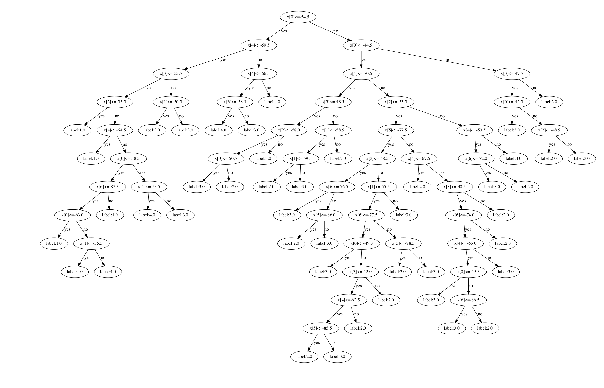

In [9]:
dt = Decision_Tree(1e-6,["x["+str(i)+"]" for i in range(7)])
dt.fit(clean_X,clean_y)
#print(dt.root)
plot_model(dt.graph, "graph")

## the visualized tree with post_pruning

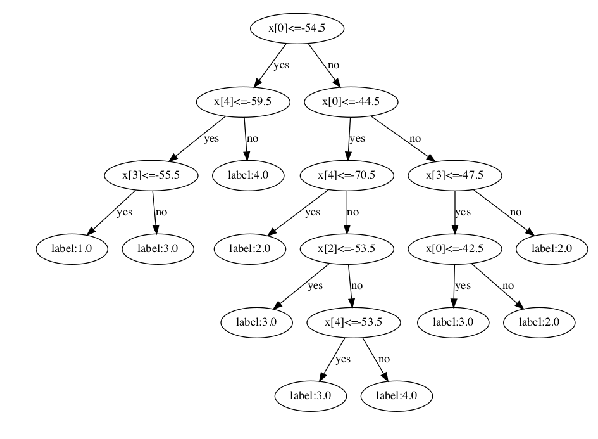

In [10]:
dt = Decision_Tree(1e-6,["x["+str(i)+"]" for i in range(7)])
dt.fit(clean_X,clean_y,post_prun = True)
#print(dt.root)
plot_model(dt.graph, "graph")

## the visualized tree without pruning

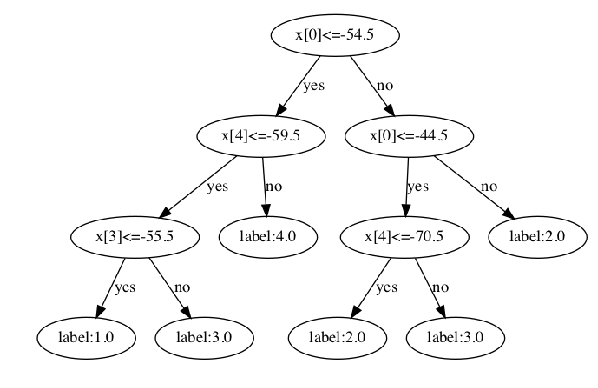

In [11]:
dt = Decision_Tree(1e-6,["x["+str(i)+"]" for i in range(7)])
dt.fit(clean_X,clean_y,pre_prun = True)
#print(dt.root)
plot_model(dt.graph, "graph")

In [12]:
def k_fold_cross_validation(K,X,y):
    '''
    devide dataset into train set and valid set
    '''
    num_examples = len(X)
    num_valid = num_examples // K
    for k in range(K):
        start = k*num_valid
        end = (k+1)*num_valid
        k_y = np.append(y[:start],y[end:])
        yield np.vstack((X[:start,:],X[end:,:])),k_y,X[start:end,:],y[start:end]

In [13]:
def cal_performance(K,X,y,pre_prun = False,post_prun = False):
    """
    calculate the average accuracy of K fold cross validation
    """
    total_train_acc = 0 #train acc sum
    total_test_acc = 0 #test acc sum
    for train_X,train_y,test_X,test_y in k_fold_cross_validation(K,X,y):
        dt.fit(train_X,train_y,pre_prun,post_prun)
        train_acc = dt.accuracy(train_X,train_y)
        test_acc = dt.accuracy(test_X,test_y)
        total_train_acc+=train_acc
        total_test_acc += test_acc
    return total_train_acc/K,total_test_acc/K

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

print("=======without pruning======")
clean_train_acc2,clean_test_acc2 = cal_performance(10,clean_X,clean_y)
noisy_train_acc2,noisy_test_acc2 = cal_performance(10,noisy_X,noisy_y)
print("10-fold cross validation : clean_train_acc:%.4f , clean_test_acc:%.4f" %(clean_train_acc2,clean_test_acc2))
print("10-fold cross validation : noisy_train_acc:%.4f , noisy_test_acc:%.4f" %(noisy_train_acc2,noisy_test_acc2))
print("=======apply pre-pruning======")
clean_train_acc,clean_test_acc = cal_performance(10,clean_X,clean_y,pre_prun = True)
noisy_train_acc,noisy_test_acc = cal_performance(10,noisy_X,noisy_y,pre_prun = True)
print("10-fold cross validation : clean_train_acc:%.4f , clean_test_acc:%.4f" %(clean_train_acc,clean_test_acc))
print("10-fold cross validation : noisy_train_acc:%.4f , noisy_test_acc:%.4f" %(noisy_train_acc,noisy_test_acc))
print("=======apply post-pruning======")
clean_train_acc,clean_test_acc = cal_performance(10,clean_X,clean_y,post_prun = True)
noisy_train_acc,noisy_test_acc = cal_performance(10,noisy_X,noisy_y,post_prun = True)
print("10-fold cross validation : clean_train_acc:%.4f , clean_test_acc:%.4f" %(clean_train_acc,clean_test_acc))
print("10-fold cross validation : noisy_train_acc:%.4f , noisy_test_acc:%.4f" %(noisy_train_acc,noisy_test_acc))

=======without pruning======
10-fold cross validation : clean_train_acc:0.9981 , clean_test_acc:0.9695
10-fold cross validation : noisy_train_acc:0.9748 , noisy_test_acc:0.8025
=======apply pre-pruning======
10-fold cross validation : clean_train_acc:0.9617 , clean_test_acc:0.9580
10-fold cross validation : noisy_train_acc:0.8770 , noisy_test_acc:0.8740
=======apply post-pruning======
10-fold cross validation : clean_train_acc:0.9783 , clean_test_acc:0.9675
10-fold cross validation : noisy_train_acc:0.8803 , noisy_test_acc:0.8765
